<a href="https://colab.research.google.com/github/jenyquist/geophysics_class/blob/main/Colab_resistivity_inversion_activity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
%matplotlib inline

## SimPEG: Simulation and Parameter Estimation in Geophysics
SimPEG is an open-source software package written in Python (naturally) to solve a variety of inversion problem in geophysics. 

### This example is based on the SimPEG documentation.
The SimPEG homepage is [here.](https://simpeg.xyz/)
You can find the example I started with [here.](https://docs.simpeg.xyz/content/tutorials/05-dcr/plot_inv_2_dcr2d.html#sphx-glr-content-tutorials-05-dcr-plot-inv-2-dcr2d-py)

Text taken verbatim from the SimPeg website is in *italics.*

2D DC inversion of Dipole Dipole array
======================================

The example simulates a 2D dipole-dipole resistivity survey over two cylinders: on more conductive than the background geology, the other more resistive.

***Dipole-Dipole array***
![](https://openei.org/w/images/thumb/1/16/Dipole-Dipole_array.jpg/400px-Dipole-Dipole_array.jpg)


***SimPEG is not simple software. Follow along the best you can, but don't worry if you don't understand all of the coding steps as long at you grasp the process***



## Import the modules needed to solve the problem and seed the random number generator

Note: The resistivity inversion  softwater package we are going to use is **not** a standard python package installed in every Colab environment -- more's the pity. So we need to install it every time we use it.  This happens in the next cell and will take a few minutues.

In [87]:
!pip install simpeg

In [88]:
# Import all of the SimPEG modules needed
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

from discretize import TreeMesh
from discretize.utils import mkvc, refine_tree_xyz

from SimPEG.utils import surface2ind_topo, model_builder
from SimPEG import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
    utils,
)
from SimPEG.electromagnetics.static import resistivity as dc
from SimPEG.electromagnetics.static.utils.static_utils import (
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)
from SimPEG.utils.io_utils.io_utils_electromagnetics import read_dcip2d_ubc

try:
    from pymatsolver import Pardiso as Solver
except ImportError:
    from SimPEG import SolverLU as Solver

The figure above shows the entire mesh with all of the padding. Let's zoom in on the part of them mesh that will underlie the electrodes.

## Download Assets

*Here we provide the file paths to assets we need to run the inversion. The path to the true model conductivity and chargeability models are also provided for comparison with the inversion results. These files are stored as a tar-file on our google cloud bucket: “https://storage.googleapis.com/simpeg/doc-assets/dcr2d.tar.gz”*

In [89]:
# storage bucket where we have the data
data_source = "https://storage.googleapis.com/simpeg/doc-assets/dcr2d.tar.gz"

# download the data
downloaded_data = utils.download(data_source, overwrite=True)

# unzip the tarfile
tar = tarfile.open(downloaded_data, "r")
tar.extractall()
tar.close()

# path to the directory containing our data
dir_path = downloaded_data.split(".")[0] + os.path.sep

# files to work with
topo_filename = dir_path + "topo_xyz.txt"
data_filename = dir_path + "dc_data.obs"

overwriting /content/dcr2d.tar.gz
   saved to: /content/dcr2d.tar.gz
Download completed!


This code above has downloaded two files. One contains the measured voltages; the other the measured surface topography. You can examine these files using the Colab file broswer and double-clicking on them to open. Try it!

In [90]:
# Load data
topo_xyz = np.loadtxt(str(topo_filename))
dc_data = read_dcip2d_ubc(data_filename, "volt", "general")

##Plot Observed Data in Pseudo-Section
Here, we demonstrate how to plot 2D data in pseudo-section. First, we plot the actual data (voltages) in pseudo-section as a scatter plot. This allows us to visualize the pseudo-sensitivity locations for our survey. Next, we plot the data as apparent conductivities in pseudo-section with a filled contour plot.

A "pseudo" (meaning "false") section is not a true representation of the subsurface. It is simply a way of displaying the raw data in the approximately correct locations, that is, each apparent resistivity value is plotted centered under the measurement location and measurements made for widely spaced electrodes are plotted deeper than for closely spaced electrodes. Examining the peusdosection helps assess data quality, but you have to run the inversion before interpreting the survey results.

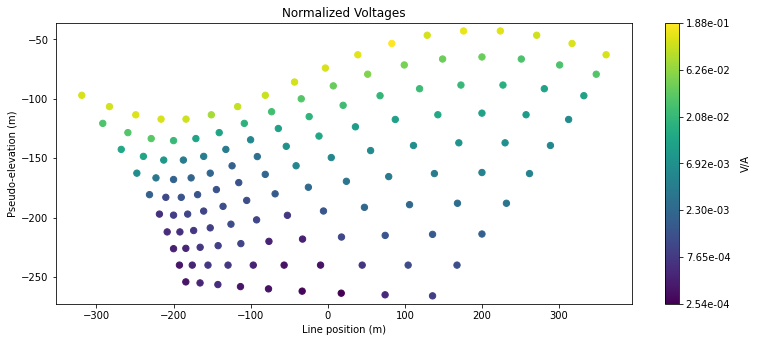

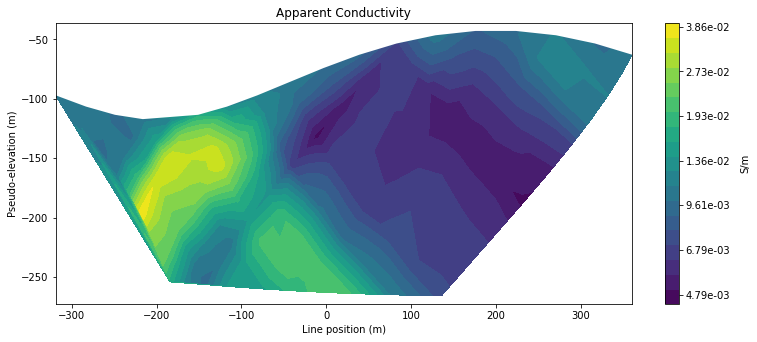

In [91]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(12, 5))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    dc_data,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    data_type="apparent conductivity",
    cbar_label="S/m",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.viridis},
)
ax1.set_title("Apparent Conductivity")
plt.show()

## What do you see in the pseudosection above?
You can tell there is a conductive zone on the left where there is a topographic low and a resistive zone on the right under the topographic high. You cannot tell much more than that with any certainty. DO NOT believe the size and shape of anomalies on a pseudosection.

## Assign Uncertainties
*Inversion with SimPEG requires that we define the uncertainties on our data. This represents our estimate of the standard deviation of the noise in our data. For DC data, the uncertainties are 10% of the absolute value.*

Uncertainties are import because they tell us how closely to fit the data.  Imagine fitting a curve to 2D data. You only want to fit the wiggles that are real, not every little noise spike. 



In [92]:
dc_data.standard_deviation = 0.05 * np.abs(dc_data.dobs)

## Create Tree Mesh
*Here, we create the Tree mesh that will be used to invert DC data.*

In [93]:
dh = 4  # base cell width
dom_width_x = 3200.0  # domain width x
dom_width_z = 2400.0  # domain width z
nbcx = 2 ** int(np.round(np.log(dom_width_x / dh) / np.log(2.0)))  # num. base cells x
nbcz = 2 ** int(np.round(np.log(dom_width_z / dh) / np.log(2.0)))  # num. base cells z

# Define the base mesh
hx = [(dh, nbcx)]
hz = [(dh, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN")

# Mesh refinement based on topography
mesh = refine_tree_xyz(
    mesh,
    topo_xyz[:, [0, 2]],
    octree_levels=[0, 0, 4, 4],
    method="surface",
    finalize=False,
)

# Mesh refinement near transmitters and receivers. First we need to obtain the
# set of unique electrode locations.
electrode_locations = np.c_[
    dc_data.survey.locations_a,
    dc_data.survey.locations_b,
    dc_data.survey.locations_m,
    dc_data.survey.locations_n,
]

unique_locations = np.unique(
    np.reshape(electrode_locations, (4 * dc_data.survey.nD, 2)), axis=0
)

mesh = refine_tree_xyz(
    mesh, unique_locations, octree_levels=[4, 4], method="radial", finalize=False
)

# Refine core mesh region
xp, zp = np.meshgrid([-600.0, 600.0], [-400.0, 0.0])
xyz = np.c_[mkvc(xp), mkvc(zp)]
mesh = refine_tree_xyz(
    mesh, xyz, octree_levels=[0, 0, 2, 8], method="box", finalize=False
)

mesh.finalize()

/usr/local/lib/python3.7/dist-packages/scipy/interpolate/interpolate.py:609: RuntimeWarning:

invalid value encountered in true_divide



## Subdivide the area of interest into a mesh
We simulate a 2D slice of of the subsurface below the resistivity line as a mesh of cells. Each cell is homogeneous and isotropic, but by changing the resistivity of the different cells we can approximate a heterogeneous earth on the granularity of the mesh. The finer the mesh the less "pixelated" our model, but the larger the set of equations that will have to be solved to invert the data, so the longer it will take to run the inversion.

Because we cannot extend our mesh to infinity, the artifical boundaries created where the mesh ends can be a problem, so what is typically done is to use small model block in the area of interest, then gradually increase the block size away from the problem domain. Large blocks "pad" the model, reducing the influence of the boundary. They yield less acurate results out at the edges of the model, but we don't care outside our region of interest.

Notice that with a "tree" mesh is very fine near the survey area and tapers off with depth. It looks sort of like a tree, with a greater density of branches in the region of interest. In the region of interest, we typically set the cell size at 1/2 or 1/4 the electrode spacing. Using a smaller cell size than that doesn't make sense as we will not have resistivity measurements on that fine a scale.

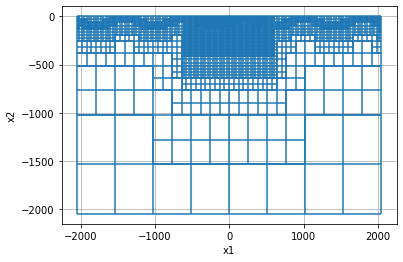

In [94]:
# Display the mesh
mesh.plotGrid()

##Project Surveys to Discretized Topography
*It is important that electrodes are not modelled as being in the air. Even if the electrodes are properly located along surface topography, they may lie above the discretized topography. This step is carried out to ensure all electrodes lie on the discretized surface.*

In [95]:
# Create 2D topography. Since our 3D topography only changes in the x direction,
# it is easy to define the 2D topography projected along the survey line. For
# arbitrary topography and for an arbitrary survey orientation, the user must
# define the 2D topography along the survey line.
topo_2d = np.unique(topo_xyz[:, [0, 2]], axis=0)

# Find cells that lie below surface topography
ind_active = surface2ind_topo(mesh, topo_2d)

# Extract survey from data object
survey = dc_data.survey

# Shift electrodes to the surface of discretized topography
survey.drape_electrodes_on_topography(mesh, ind_active, option="top")

# Reset survey in data object
dc_data.survey = survey

## Starting/Reference Model and Mapping on Tree Mesh
*Here, we would create starting and/or reference models for the DC inversion as well as the mapping from the model space to the active cells. Starting and reference models can be a constant background value or contain a-priori structures. Here, the starting model is the natural log of 0.01 S/m.*

Think of this starting model as an initial guess at the subsurface resistivity. What happens during inversion is an interative process:
- Start with a guess at the subsurface resistivity.
- Use this guess to calculate what voltages you would measure.
- Find the areas of misfit where the calculated voltages do not match what was measured.
- Adjust the model to make the appropriate mesh cells more or less resistive.
- Repeat this process until the misfit comes down to the measurement error.
- STOP. Do not fit the noise!

### To summarize
At this point we have:
- We have loaded our data, including topography info.
- Created a mesh with finer discretization in our survey area.
- Positioned our electrodes
- Created a starting resistivity model

In [96]:
# Define conductivity model in S/m (or resistivity model in Ohm m)
air_conductivity = np.log(1e-8)
background_conductivity = np.log(1e-2)
background_conductivity = np.log(1e-1)

active_map = maps.InjectActiveCells(mesh, ind_active, np.exp(air_conductivity))
nC = int(ind_active.sum())

conductivity_map = active_map * maps.ExpMap()

# Define model
starting_conductivity_model = background_conductivity * np.ones(nC)

## Define the Physics of the DC Simulation
*Here, we define the physics of the DC resistivity problem.*

SimPEG can be used to solve many types of geophysical inversion (e.g, gravity, magnetics, electromagnetics). So we have to tell it this is a resistivity problem.

In [97]:
simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=survey, sigmaMap=conductivity_map, Solver=Solver
)

/usr/local/lib/python3.7/dist-packages/SimPEG/utils/code_utils.py:413: FutureWarning:

Solver has been deprecated, please use simulation.solver. It will be removed in version 0.16.0 of SimPEG.

/usr/local/lib/python3.7/dist-packages/SimPEG/utils/code_utils.py:420: FutureWarning:

Solver has been deprecated, please use simulation.solver. It will be removed in version 0.16.0 of SimPEG.



##Define DC Inverse Problem
*The inverse problem is defined by 3 things:*

1. *Data Misfit: a measure of how well our recovered model explains the field data*

2. *Regularization: constraints placed on the recovered model and a priori information*

3. *Optimization: the numerical approach used to solve the inverse problem*

**What is "regularization" and does it involve prunes?**

Well no, but regularization is necessary for inversion. The problem is that there are an infinite number of ways we can adjust the resistivities of the model blocks that will fit the data equally well. **Inversion is non-unique!** We have to provide addition information to arrive at a single "best" solution. Typically, the constraint we provide is to "regularize" the solution by penalizing departures from the starting guess. Only if changing the resistivity value of a given model block really, really improves the fit do we allow it.

This means the started model is really important!

In [98]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=dc_data, simulation=simulation)

# Define the regularization (model objective function)
reg = regularization.Simple(
    mesh,
    indActive=ind_active,
    mref=starting_conductivity_model,
    alpha_s=0.01,
    alpha_x=1,
    alpha_y=1,
)

reg.mrefInSmooth = True  # Reference model in smoothness term

# Define how the optimization problem is solved. Here we will use an
# Inexact Gauss Newton approach.
opt = optimization.InexactGaussNewton(maxIter=40)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

## Define DC Inversion Directives
*Here we define any directives that are carried out during the inversion. This includes the cooling schedule for the trade-off parameter (beta), stopping criteria for the inversion and saving inversion results at each iteration.*

In [99]:
# Apply and update sensitivity weighting as the model updates
update_sensitivity_weighting = directives.UpdateSensitivityWeights()

# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Set the rate of reduction in trade-off parameter (beta) each time the
# the inverse problem is solved. And set the number of Gauss-Newton iterations
# for each trade-off paramter value.
beta_schedule = directives.BetaSchedule(coolingFactor=3, coolingRate=2)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Update preconditioner
update_jacobi = directives.UpdatePreconditioner()

directives_list = [
    update_sensitivity_weighting,
    starting_beta,
    beta_schedule,
    save_iteration,
    target_misfit,
    update_jacobi,
]

## Create the targets we wish to model
We are putting two cylinders into a homogeneous halfspace

## Running the DC Inversion

*To define the inversion object, we need to define the inversion problem and the set of directives. We can then run the inversion.*

### Finally!  We are ready to run the inversion.
Note: This will take a while because of all the iterations.

In [100]:
# Here we combine the inverse problem and the set of directives
dc_inversion = inversion.BaseInversion(inv_prob, directiveList=directives_list)

# Run inversion
recovered_conductivity_model = dc_inversion.run(starting_conductivity_model)


        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.93e+01  2.04e+04  0.00e+00  2.04e+04    2.34e+02      0              
   1  1.93e+01  1.50e+04  5.43e+00  1.51e+04    2.84e+03      1              
   2  6.43e+00  9.55e+03  9.95e+00  9.61e+03    1.80e+03      0              
   3  6.43e+00  4.22e+03  1.35e+01  4.31e+03    6.80e+02      0              
   4  2.14e+00  1.70e+03  1.81e+01  1.74e+03    2.39e+02      2              
   5  2.14e+00  1.06e+03  2.10e+01  1.10e+03    1.46e+02      1   Skip BFGS  
   6  7.14e-01  6.87e+02  3.08e+01  7.09e+02    1.31e+02      0              
   7  7.14e-01  5.64e+02  3.39e+01

/usr/local/lib/python3.7/dist-packages/SimPEG/maps.py:1077: RuntimeWarning:

overflow encountered in exp



------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 2.0417e+03
0 : |xc-x_last| = 7.2035e+01 <= tolX*(1+|x0|) = 1.5610e+01
0 : |proj(x-g)-x|    = 4.8497e+01 <= tolG          = 1.0000e-01
0 : |proj(x-g)-x|    = 4.8497e+01 <= 1e3*eps       = 1.0000e-02
0 : maxIter   =      40    <= iter          =     16
------------------------- DONE! -------------------------


## Recreate True Conductivity Model
The data you just inverted was for a simulated survey. So we will now look at the subsurface structure you would get if the resistivity data collection and inversion were perfect.

In [101]:
true_background_conductivity = 1e-2
true_conductor_conductivity = 1e-1
true_resistor_conductivity = 1e-3

true_conductivity_model = true_background_conductivity * np.ones(len(mesh))

ind_conductor = model_builder.getIndicesSphere(np.r_[-120.0, -180.0], 60.0, mesh.gridCC)
true_conductivity_model[ind_conductor] = true_conductor_conductivity

ind_resistor = model_builder.getIndicesSphere(np.r_[120.0, -180.0], 60.0, mesh.gridCC)
true_conductivity_model[ind_resistor] = true_resistor_conductivity

true_conductivity_model[~ind_active] = np.NaN

## Plotting True and Recovered Conductivity Model

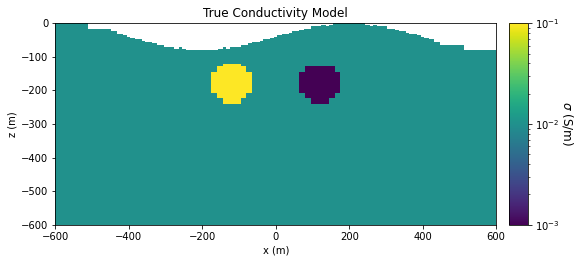

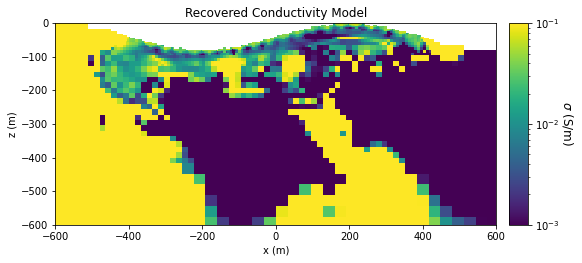

In [102]:
# Plot True Model
norm = LogNorm(vmin=1e-3, vmax=1e-1)

fig = plt.figure(figsize=(9, 4))
ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
im = mesh.plot_image(
    true_conductivity_model, ax=ax1, grid=False, pcolor_opts={"norm": norm}
)
ax1.set_xlim(-600, 600)
ax1.set_ylim(-600, 0)
ax1.set_title("True Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

# # Plot Recovered Model
fig = plt.figure(figsize=(9, 4))

recovered_conductivity = conductivity_map * recovered_conductivity_model
recovered_conductivity[~ind_active] = np.NaN

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    recovered_conductivity, normal="Y", ax=ax1, grid=False, pcolorOpts={"norm": norm}
)
ax1.set_xlim(-600, 600)
ax1.set_ylim(-600, 0)
ax1.set_title("Recovered Conductivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(ax2, norm=norm, orientation="vertical")
cbar.set_label(r"$\sigma$ (S/m)", rotation=270, labelpad=15, size=12)

plt.show()

This is a 2D model. That means we are assuming the geology is unchanging perpendicular to the cross-section we are modeling. So a circular object in the model is really slice through a cylinder of infinite extent perpendicular to the slice. 

Notice that the conductive and resistivity anomalies mapped by resistivity inversion do not have sharp boundaries; the transition from background resistivity to conductive or resistive cylinder is smooth, not abrupt. That the prunes at work, er, the regularization. To find a unique solution, we forced the inversion to be a smooth as possible while still honoring the data. 

Remember! Inversion is non-unique. In fact, performing the same resistivity survey over the true model and the one returned by the inversion would produce the same data set. In that sense, there is nothing wrong with the inversion result. This is why you geologic knowledge is important when interpreting the results. You have to judge whether an abrupt or gradational boundary is more geologically reasonable. Sometimes abrupt makes sense (e.g., and intrusive dike); sometimes gradational makes sense (e.g., an erosional boundary). 

Ideally, geophysical surveys guide follow-up efforts to collect "ground truth." Typically, we drill the anomaly if we need to learn more.

## Plotting Predicted DC Data and Misfit

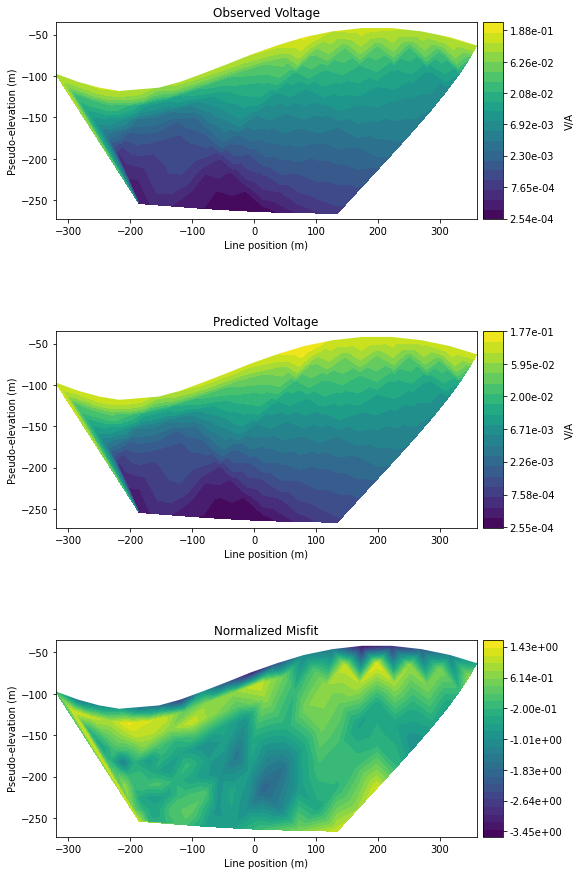

In [103]:
# Predicted data from recovered model
dpred = inv_prob.dpred
dobs = dc_data.dobs
std = dc_data.standard_deviation

# Plot
fig = plt.figure(figsize=(9, 13))
data_array = [np.abs(dobs), np.abs(dpred), (dobs - dpred) / std]
plot_title = ["Observed Voltage", "Predicted Voltage", "Normalized Misfit"]
plot_units = ["V/A", "V/A", ""]
scale = ["log", "log", "linear"]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):

    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        survey,
        data_array[ii],
        "contourf",
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": mpl.cm.viridis},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

Overall, the fit looks pretty good. The measured pseudosection and the one predicted based on our inverted resistivity model match well.

## Important takeaways
* Inversion of resistivity data is non-unique
* Regularization of the inversion smooths the result
* Inversion finds both the conductive and resistive cylinder but....
* The sharp boundary becomes smoothed
* The contrast in conducivity between the cylinders and the background is reduced.

***To illustrate the last two points, here is the plot again without the cylinder boundaries superimposed.***

## Student Challenges

I hope this exercise has give you a sense of the power and limitations of resistivity tomography. Here are some
experiments to try on your own. After each adjustment just run all cells.

I told you that starting model was important. If your guess for the starting model is way off, it will affect the final inversion. Try changing the initial background resistivity. 

Replace

background_conductivity = np.log(1e-2)

with

background_conductivity = np.log(1e-3)

Note: The inversion will require more iterations and take longer to run as you started far from the correct solution.

What does this new inversion result tell you? Does it still fit the data well?


## Final Thoughts

We used SimPEG to perform the inversion because it is written in Python, so we can (if we want to) see all the code and control all of the parameters. In practice, most consultants will run a commercial resistivity inversion code where many of the parameters have by pre-selected with values that work well in most cases and you just have to load the data and click run. 

This makes inversion easy, but maybe too easy?